# Building a Handwritten Digits Classifier

In this project we will first of all consider the complexity behind image classification, then we will evaluate limitations of traditional machine learning models for image classification and finally we will develop few different neural networks for image classification.

Image classification is a hard task for different reasons: first of all the image in a training set is high dimensional, considering that each pixel in an image is a feature; morevorer, sometimes we lose details which can be useful during the training process since the images are often downsampled. Finally the features in an image do not have linear or nonlinear relationship that can be learned with a traditional model like linear or logistic regression (e.g. in grayscale, each pixel is just represented as a brightness value ranging from 0 to 256). 
Thanks to it's ability in learning hierarchical representations, deep learning is effective in image classification. Indeed each layer will learn a specific intermediate representation and each successive layer uses weights from previous layers to try to learn more complex representations. 

The dataset we will use for this project is the one stored in skleran.datasets, that can be accessed by the function *load_digits()* and that is a copy of the [hand-written digits dataset](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits) from UCI.


### Summary of the Results

Both k-nn method and one single layer with 8 neurons have good accuracy in the cassification of handwritten digits. Nevertheless, if one considers all the downsides of the k-nn algorithm, e.g. high memory usage and the fact that there is no model representation to debug and explore, the developed neural network seems to be the best option.

## Dataset Evaluation 

Let us first import the needed libraries, as follows:

In [1]:
import os
import pandas as pd
import json
import matplotlib
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns    # seaborn is commonly imported as `sns`
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_digits
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

In [2]:
raw_data = load_digits()

In [3]:
raw_data

{'DESCR': ".. _digits_dataset:\n\nOptical recognition of handwritten digits dataset\n--------------------------------------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 5620\n    :Number of Attributes: 64\n    :Attribute Information: 8x8 image of integer pixels in the range 0..16.\n    :Missing Attribute Values: None\n    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)\n    :Date: July; 1998\n\nThis is a copy of the test set of the UCI ML hand-written digits datasets\nhttp://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits\n\nThe data set contains images of hand-written digits: 10 classes where\neach class refers to a digit.\n\nPreprocessing programs made available by NIST were used to extract\nnormalized bitmaps of handwritten digits from a preprinted form. From a\ntotal of 43 people, 30 contributed to the training set and different 13\nto the test set. 32x32 bitmaps are divided into nonoverlapping blocks of\n4x4 and the number of

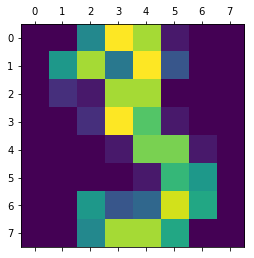

In [4]:
# Let us explore what is stored in the image part of the raw_data
import matplotlib.pyplot as plt 
%matplotlib inline
#plt.gray() 
plt.matshow(raw_data.images[3]) 
plt.show() 

As we can see *raw_data* contains several fields, in particular: *data, images, target and target_name*. We can use the *data* field in order to create the dataframe.

In [5]:
# Convert raw_data.data into a dataframe unsing pandas and store the target values into the variable labels
df = pd.DataFrame(raw_data.data)
labels = raw_data.target

In [6]:
df.shape

(1797, 64)

Because dataframes are a tabular representation of data, each image is represented as a row of pixel values (1 x 64). To visualize an image from the dataframe, we need to reshape the image back to its original dimensions (8 x 8 pixels). To visualize the image, we need to reshape these pixel values back into the 8 by 8 and plot them on a coordinate grid.

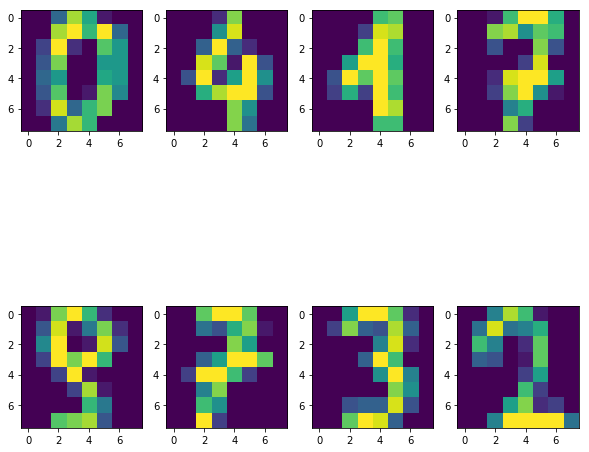

In [7]:
# Let us consider specific rows of the dataframe which are  
# associated to specific images
images = [0, 100, 200, 300, 1100, 1200, 1300, 1400]
images_collect = []
# let us collect the images in a list
for im in images:
    first_image = df.iloc[im]
    np_image = first_image.values
    images_collect.append(np_image.reshape(8,8))
    
# Let us plot the images in a scatter plot grid
f, axes = plt.subplots(2, 4, figsize=(10,10))
for idx in range (axes.shape[1]):
    axes[0, idx].imshow(images_collect[idx])
    axes[1, idx].imshow(images_collect[idx+4])
    

As expected by reshaping each row of the dataframe we can obtain again the original images.

## Predicting Handwritten Digits

In this project we will explore two main algortihms for predicting handwritten digits: k-nearest neighbors and neural networks.

### K-nearest neighbors

While linear and logistic regression models make assumptions about the linearity between the features and the output labels, the k-nearest neighbors (k-nn) algorithm make no such assumption. This allows k-nn to capture nonlinearity in the data since it does not have a specific model representation (hence why it's referred to as an algorithm and not a model).

The k-nn algorithm compares every unseen observation in the test set to all (or many, as some implementations constrain the search space) training observations to look for similar (or the "nearest") observations. Then, the algorithm finds the label with the most nearby observations and assigns that as the prediction for the unseen observation.

Let us first define a useful function called **cross_validation** that realizes inside a k-folds cross validation given the model to be used, the features and the labels and finally the number of folds.

In [8]:
def cross_validate(model, features, labels, folds):
    # Let us use KFold to provide train/test indices to split data into train/test sets
    kf = KFold(n_splits=folds, shuffle=True, random_state=3)
    mse_values_test=[]
    mse_values_train=[]
    acc_values_test=[]
    acc_values_train=[]
    iterat = 0
    print('------------')
    # Iterate through over each fold.
    for train_index, test_index in kf.split(features):
        iterat = iterat+1
        print('iteration #' + str(iterat))
    # Training and test sets.
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

    # Fit the model and make predictions using both the test and train sets
        model.fit(X_train, y_train)
        predictions_test = model.predict(X_test)
        predictions_train = model.predict(X_train)
    # Calculate mse and accuracy values for this fold (train and test).
        mse_test = mean_squared_error(y_test, predictions_test)
        mse_train = mean_squared_error(y_train, predictions_train)
        acc_test = accuracy_score(y_test, predictions_test)
        acc_train = accuracy_score(y_train, predictions_train)

    # Append to arrays to calculate overall average mse values.
        mse_values_test.append(mse_test)
        mse_values_train.append(mse_train)
        acc_values_test.append(acc_test)
        acc_values_train.append(acc_train)
    # compute and return average accuracy and mean squared error fro train and test sets.    
    avg_mse_test = np.mean(mse_values_test)
    avg_mse_train = np.mean(mse_values_train)
    avg_acc_test = np.mean(acc_values_test)
    avg_acc_train = np.mean(acc_values_train)
    return(avg_mse_test, avg_mse_train, avg_acc_test, avg_acc_train)
    

Let us implement ten k-nn models with different k value (from 1 ot 10). For each model we will use the function **cross_validate** to compute the average accuracy and mean squared error for the test and the train set.

In [9]:
mse_vect_test = []
mse_vect_train = []
acc_vect_test = []
acc_vect_train = []
k_values = [1, 2, 3, 4,  5, 6, 7, 8, 9, 10]
for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    avg_mse_test, avg_mse_train, avg_acc_test, avg_acc_train = cross_validate(model, df, labels, 4)
    mse_vect_test.append(avg_mse_test)
    mse_vect_train.append(avg_mse_train)
    acc_vect_test.append(avg_acc_test)
    acc_vect_train.append(avg_acc_train)

------------
iteration #1
iteration #2
iteration #3
iteration #4
------------
iteration #1
iteration #2
iteration #3
iteration #4
------------
iteration #1
iteration #2
iteration #3
iteration #4
------------
iteration #1
iteration #2
iteration #3
iteration #4
------------
iteration #1
iteration #2
iteration #3
iteration #4
------------
iteration #1
iteration #2
iteration #3
iteration #4
------------
iteration #1
iteration #2
iteration #3
iteration #4
------------
iteration #1
iteration #2
iteration #3
iteration #4
------------
iteration #1
iteration #2
iteration #3
iteration #4
------------
iteration #1
iteration #2
iteration #3
iteration #4


In [10]:
for i in range (len(acc_vect_test)):
    print 'The Accuracy for k = ',i+1,' is acc = ', acc_vect_test[i]

The Accuracy for k =  1  is acc =  0.9860876020786935
The Accuracy for k =  2  is acc =  0.984419698094531
The Accuracy for k =  3  is acc =  0.988870329126454
The Accuracy for k =  4  is acc =  0.9849764909675823
The Accuracy for k =  5  is acc =  0.9855320465231378
The Accuracy for k =  6  is acc =  0.9838641425389755
The Accuracy for k =  7  is acc =  0.9833061123484287
The Accuracy for k =  8  is acc =  0.9821925266023261
The Accuracy for k =  9  is acc =  0.9788567186340015
The Accuracy for k =  10  is acc =  0.9794147488245484


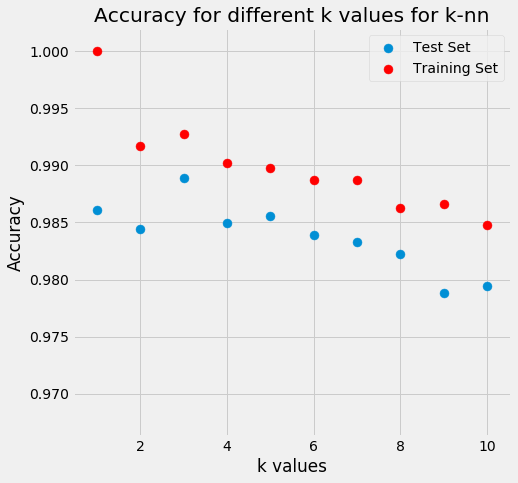

In [11]:
# plot accuracy results
plt.style.use('fivethirtyeight')
plt.figure(figsize=(7,7))
plt.scatter(k_values, acc_vect_test, s=80)
plt.scatter(k_values, acc_vect_train, s=80, c = 'red')
plt.title('Accuracy for different k values for k-nn')
plt.legend(['Test Set', 'Training Set'])
plt.ylabel('Accuracy')
plt.xlabel('k values')
plt.show()

The previous plot shows a maximum accuracy for k=3. For smaller values of k it is possible that the model is too complex and it overfits (which means that, even though the train accuracy could be higher, in the case of test accuracy, as computed in the function **cross_validate**, the accuracy will be lower). On the other hand, for highest values of k, it may underfit and thus the accuracy decreases. 
In the case of training accuracy, as expected, there is a monotonic decrease of the accuracy with respect to the k values. It is clear, in this case, that for low values of k, e.g. k = 1, 2, the model overfits (big difference between train and test accuracy).

#### Observations:
There are a few downsides to using k-nearest neighbors:

- high memory usage (for each new unseen observation, many comparisons need to be made to seen observations)
- no model representation to debug and explore

Let's now try a neural network with a single hidden layer.

### Neural Network with a single hidden layer

We will train and test several neural netweork model with a single layer with different numbers of neurons. In particular n = 8, 16, 32, 64, 128, 256. For each model we will use the function **cross_validate** to compute the mean squared error and the accuracy of the model in predicting the handwritten digits.

In [13]:
N = [8, 16, 32, 64, 128, 256]
mse_vect_test = []
mse_vect_train = []
acc_vect_test = []
acc_vect_train = []
for n in N:
    print 'number of neurons: ', n
    model = MLPClassifier(hidden_layer_sizes=(n,))
    avg_mse_test, avg_mse_train, avg_acc_test, avg_acc_train = cross_validate(model, df, labels, 4)
    mse_vect_test.append(avg_mse_test)
    mse_vect_train.append(avg_mse_train)
    acc_vect_test.append(avg_acc_test)
    acc_vect_train.append(avg_acc_train)

number of neurons:  8
------------
iteration #1
iteration #2
iteration #3
iteration #4
number of neurons:  16
------------
iteration #1
iteration #2
iteration #3
iteration #4
number of neurons:  32
------------
iteration #1
iteration #2
iteration #3
iteration #4
number of neurons:  64
------------
iteration #1
iteration #2
iteration #3
iteration #4
number of neurons:  128
------------
iteration #1
iteration #2
iteration #3
iteration #4
number of neurons:  256
------------
iteration #1
iteration #2
iteration #3
iteration #4


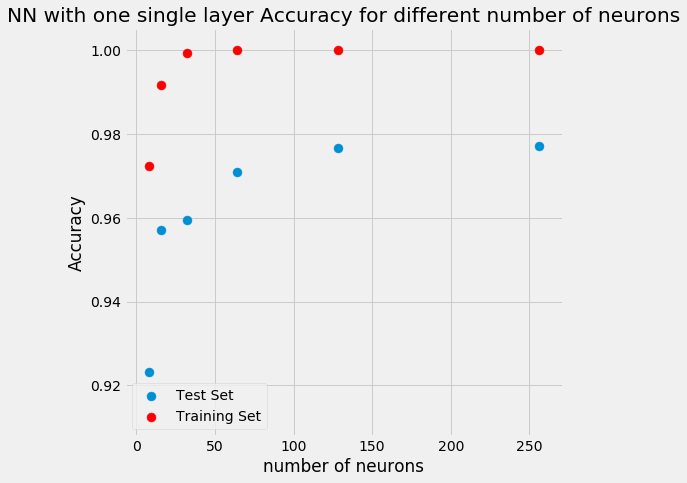

In [14]:
# plot accuracy results
acc_vect_nn_test = acc_vect_test
acc_vect_nn_train = acc_vect_train
plt.style.use('fivethirtyeight')
plt.figure(figsize=(7,7))
plt.scatter(N, acc_vect_nn_test, s=80)
plt.scatter(N, acc_vect_nn_train, s=80, c = 'red')
plt.title('NN with one single layer Accuracy for different number of neurons')
plt.ylabel('Accuracy')
plt.xlabel('number of neurons')
plt.legend(['Test Set', 'Training Set'])
plt.show()

In [15]:
for i, n in enumerate (N):
    print 'The Accuracy for number of neurons = ',n,' is acc = ', acc_vect_nn_test[i]

The Accuracy for number of neurons =  8  is acc =  0.9232083642662707
The Accuracy for number of neurons =  16  is acc =  0.9571492204899776
The Accuracy for number of neurons =  32  is acc =  0.959382578569661
The Accuracy for number of neurons =  64  is acc =  0.97106285572878
The Accuracy for number of neurons =  128  is acc =  0.976632021776788
The Accuracy for number of neurons =  256  is acc =  0.9771851026973521


Adding more neurons to a single hidden layer vastly improved the classification accuracy, without a big overfitting (at least up to the tested number of neurons (256)).

Let's try to use two hidden layers and continue to increase the number of neurons in each layer.

### Neural Network with two hidden layers

Let us modify the neural network training pipeline to use 2 hidden layers instead in the network, with 64 neurons each.

In [16]:
model = MLPClassifier(hidden_layer_sizes=(64,64))
avg_mse_test, avg_mse_train, avg_acc_test, avg_acc_train = cross_validate(model, df, labels, 4)
print('The accuracy of the test set is = ' + str(avg_acc_test))
print('The accuracy of the training set is = ' + str(avg_acc_train))

------------
iteration #1
iteration #2
iteration #3
iteration #4
The accuracy of the test set is = 0.9699455580301906
The accuracy of the training set is = 1.0


We can compare these results with a neural network with only one layer (but with the same number of neurons)

In [17]:
model = MLPClassifier(hidden_layer_sizes=(64,))
avg_mse_test, avg_mse_train, avg_acc_test, avg_acc_train = cross_validate(model, df, labels, 4)
print('The accuracy of the test set is = ' + str(avg_acc_test))
print('The accuracy of the training set is = ' + str(avg_acc_train))

------------
iteration #1
iteration #2
iteration #3
iteration #4
The accuracy of the test set is = 0.9677307597129423
The accuracy of the training set is = 1.0


Using more hidden layers slighly improve the accuracy of the classification but it is known to increase also the amount of overfitting that happens. To help us prevent overfitting, let's increase the number of folds we use for k-fold cross validation to 6 while testing networks with 3 hidden layers.

In [18]:
neurons = [10, 64, 128, 256]
acc_test = []
acc_train = []
for n in neurons:
    model = MLPClassifier(hidden_layer_sizes=(n, n, n))
    avg_mse_test, avg_mse_train, avg_acc_test, avg_acc_train = cross_validate(model, df, labels, 6)
    acc_test.append(avg_acc_test)
    acc_train.append(avg_acc_train)  

------------
iteration #1
iteration #2
iteration #3
iteration #4
iteration #5
iteration #6
------------
iteration #1
iteration #2
iteration #3
iteration #4
iteration #5
iteration #6
------------
iteration #1
iteration #2
iteration #3
iteration #4
iteration #5
iteration #6
------------
iteration #1
iteration #2
iteration #3
iteration #4
iteration #5
iteration #6


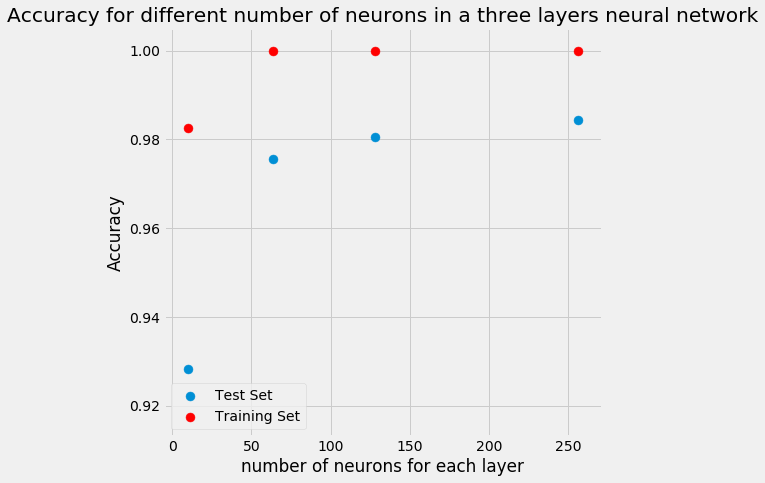

In [19]:
# plot results
plt.style.use('fivethirtyeight')
plt.figure(figsize=(7,7))
plt.scatter(neurons, acc_test, s=80)
plt.scatter(neurons, acc_train, s=80, c = 'red')
plt.title('Accuracy for different number of neurons in a three layers neural network')
plt.legend(['Test Set', 'Training Set'])
plt.ylabel('Accuracy')
plt.xlabel('number of neurons for each layer')
plt.show()

In [21]:
for i, n in enumerate (neurons):
    print 'The Accuracy for number of neurons = ',n,' is acc = ', acc_test[i]

The Accuracy for number of neurons =  10  is acc =  0.9282218506131551
The Accuracy for number of neurons =  64  is acc =  0.9755146785581568
The Accuracy for number of neurons =  128  is acc =  0.980522110739502
The Accuracy for number of neurons =  256  is acc =  0.9844202898550724


Increasing the number of folders in the cross validation helps in reducing the gap between the accuracy of the training set and the one of the test set when more neurons are added in each layer: the accuracy of the training set remains at 1.00 while the one of the one of the test set increases from 0.97 (when we use 4-fold cross validation) to 0.98 (when 6 folders are used). 

## Conclusion

In this project we evaluate two different machine learning methods to classify handwritten digits: k-nearest neighboor and neural network.
k-nearest neighboor performances, as expected, depend on the value of the number of neighboors (k) we select in order to assign a specific label to our data sample. For very small k values the method clearly overfit indeed the accuracy given by the test set and the one of the training set diverge. For bigger values of k, the model is too simple and the accuracy decreases significantly. The best value of k that provides a good accuracy is k=3, with an accuracy on the training set of almost 0.99. 
For the neural network we started by considering one neural network with one single layer and we test it while changing the number of neurons inside the hidden layer. Increasing the number of neurons results in an increse of the overall accuracy (in particular from 0.89 for 8 neurons to 0.98 for 256 neurons). After that we increase the number of layers. One problem with the increment of the number of layer could be the the overfitting so in order to limit it we increase the number of folders in the cross validation process and we could appreciate a slight increment of the accuracy (from 0.982 to 0.984). However such increment does not justify the addition of two more layers in the model. 

From this analysis it looks like that the best models/methods, which are k-nn with k=3 (accuracy = 0.99) and one neural network with one single layer with 8 neurons (accuracy = 0.98), have similar performances. Although the k-nn method has a slightly better accuracy, beacuse of the downsides explained before maybe not be the best choice. 
The neural network with one single layer with 8 neurons can be considered, for the previous reasonings, the best option to classify handwritten digit.